In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import glob
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from datetime import datetime
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [ ]:
def get_day_load_data(load_path):
    '''read csv data at load_path and return it in a numpy matrix'''
    data = pd.read_csv(load_path)
    date_ = load_path.split('/')[-1][:-4] # get date of '01-10-2017' format
    data['date'] = datetime.strptime(date_, "%d-%m-%Y").date()
    data['time'] += ':00'
    data['datetime'] = pd.to_timedelta(data['time'])
    data['hour'] = data['datetime'].dt.seconds // 3600 
    return data.to_numpy()

In [ ]:
def get_30min_wise_data(day_load_data):
    '''Returns time, day temp, humidity and load values for each 30mins in a numpy matrix'''
    data = []
    for i in range(0, 288, 6): # SLDC load data has time step of 5 mins, so total 24 * (60 // 5)
        load = day_load_data[i][1]
        day = day_load_data[i][2].weekday()
        
        try:
            humidity = 55
        except Exception as e:
            humidity = 50 # some dirt values in data
        try:
            temp = float(day_whether_data[i//6][0]) # i//6 because whether data is already in 30 min step size
        except Exception as err:
            temp = 28 # aiyvi
        data.append([i, day, temp, humidity, load])
    return np.asarray(data)

In [ ]:
def get_data(data_list, shuffle=True):
    '''Return data of all csv files in SLDC_Data/ folder in matrix form'''
    data = []
    for load_path in data_list:
        try:
            # whether_path = load_path.replace('SLDC_Data', 'Whether_Data')
            day_load_data = get_day_load_data(load_path)
            # day_whether_data = pd.read_csv(whether_path)
            day_data = get_30min_wise_data(day_load_data)
            data.append(day_data)
        except Exception as e:
            print(load_path, e)
    data = np.asarray(data) # (115, 48, 5)
    data = data.reshape(-1, 5) # (5520, 5)
    if shuffle: np.random.shuffle(data)
    return data

In [ ]:
# data preprocessing
data_list = glob.glob('/content/drive/MyDrive/SLDC_Data/*/*/*.csv')
train, test = train_test_split(data_list, test_size=0.1)
train_data = get_data(train)
X_train = train_data[:, :-1] # features
Y_train = train_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

/content/drive/MyDrive/SLDC_Data/2023/02/03-02-2023.csv index 168 is out of bounds for axis 0 with size 167
/content/drive/MyDrive/SLDC_Data/2023/02/24-02-2023.csv index 282 is out of bounds for axis 0 with size 282
/content/drive/MyDrive/SLDC_Data/2023/01/28-01-2023.csv index 276 is out of bounds for axis 0 with size 275
/content/drive/MyDrive/SLDC_Data/2022/12/15-12-2022.csv index 216 is out of bounds for axis 0 with size 215
/content/drive/MyDrive/SLDC_Data/2023/02/01-02-2023.csv index 180 is out of bounds for axis 0 with size 177
/content/drive/MyDrive/SLDC_Data/2022/10/06-10-2022.csv index 228 is out of bounds for axis 0 with size 228
/content/drive/MyDrive/SLDC_Data/2023/01/02-01-2023.csv index 192 is out of bounds for axis 0 with size 190
/content/drive/MyDrive/SLDC_Data/2022/12/23-12-2022.csv index 120 is out of bounds for axis 0 with size 119
/content/drive/MyDrive/SLDC_Data/2023/01/31-01-2023.csv index 252 is out of bounds for axis 0 with size 251
/content/drive/MyDrive/SLDC_

In [ ]:
X_train

array([[204.,   3.,  28.,  55.],
       [ 42.,   0.,  28.,  55.],
       [270.,   4.,  28.,  55.],
       ...,
       [198.,   4.,  28.,  55.],
       [138.,   2.,  28.,  55.],
       [  0.,   1.,  28.,  55.]])

In [ ]:
# rescale the data to 0-1 values`
feature_scaler = MinMaxScaler(feature_range=(0, 1))
load_scaler = MinMaxScaler(feature_range=(0, 1)) # try StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
Y_train = load_scaler.fit_transform(Y_train)

In [ ]:
def getModel():
    model = Sequential()
    model.add(Dense(256, input_shape=(4, )))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model

In [ ]:
model = getModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/50
161/161 [==============================] - 2s 6ms/step - loss: 0.0234 - val_loss: 0.0196
Epoch 2/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 3/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 4/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0160
Epoch 5/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 6/50
161/161 [==============================] - 1s 8ms/step - loss: 0.0146 - val_loss: 0.0153
Epoch 7/50
161/161 [==============================] - 1s 8ms/step - loss: 0.0147 - val_loss: 0.0165
Epoch 8/50
161/161 [==============================] - 1s 8ms/step - loss: 0.0144 - val_loss: 0.0152
Epoch 9/50
161/161 [==============================] - 1s 8ms/step - loss: 0.0143 - val_loss: 0.0154
Epoch 10/50
161/161 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0162

In [ ]:
def predict(data):
    '''selects a date in data and plots the predicted curve using the trained model'''
    try:
        x = np.random.randint(len(data)) # to select a date in data data
        data_data = get_data([data[x]], shuffle=False)
        X_data = data_data[:, :-1] # features
        Y_data = data_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

        X_data = feature_scaler.fit_transform(X_data)
        Y_data = load_scaler.fit_transform(Y_data)

        preds = model.predict(X_data)
        preds = load_scaler.inverse_transform(preds)
        Y_ = load_scaler.inverse_transform(Y_data)

        plt.plot(range(len(Y_)), Y_)
        plt.plot(range(len(preds)), preds)
        plt.legend(['actual', 'pred'])
        plt.title(data[x])
        plt.show()
    except Exception as e:
        print('Err in data', e)

2/2 [==============================] - 0s 3ms/step


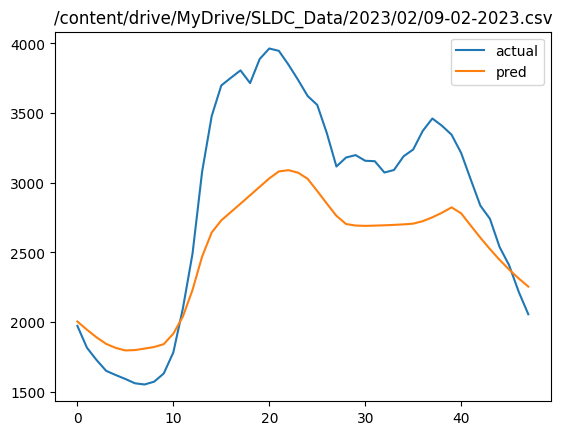

In [ ]:
# prediction on test data
predict(test)

2/2 [==============================] - 0s 6ms/step


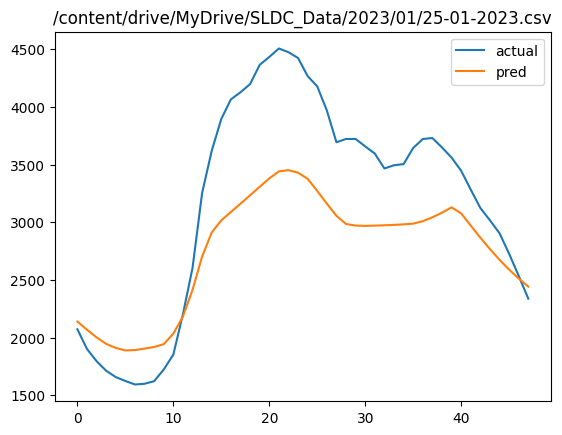

In [ ]:
# prediction on train data
predict(train)

179/179 [==============================] - 0s 2ms/step
2928 2978


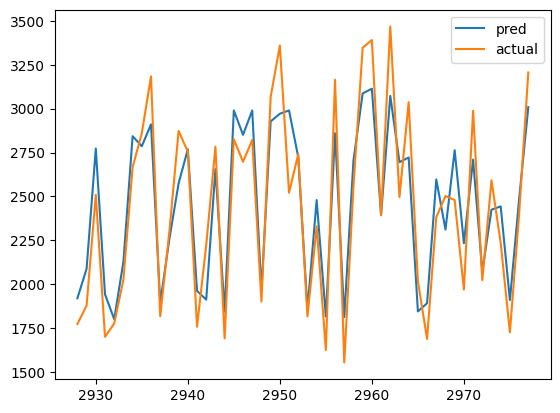

In [ ]:
# prediction on train data as a whole

preds = model.predict(X_train)
preds = load_scaler.inverse_transform(preds)
Y_ = load_scaler.inverse_transform(Y_train)

x = np.random.randint(len(preds))
x_max = 50
print(x,x+x_max)
plt.plot(range(x, x+x_max), preds[x:x+x_max])
plt.plot(range(x, x+x_max), Y_[x:x+x_max])
plt.legend(['pred', 'actual'])
plt.show()